In [1]:
import matplotlib.pyplot as plt
import sys
import time
import scipy.io as io
import os
from os import listdir
import glob
import time

import csv
import cv2
import numpy as np
from opt_flow import draw_flow

from scipy import ndimage as ndi

import math
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import binary_closing, binary_opening, binary_dilation, disk,remove_small_objects,label,binary_erosion
from skimage.color import label2rgb
from skimage import data, color, io, img_as_float

from scipy.signal import find_peaks
from skimage.filters import gaussian

import math
import pandas as pd

def numpy_fill(arr):
    '''Solution provided by Divakar.'''
    mask = np.isnan(arr)
    idx = np.where(~mask,np.arange(mask.shape[1]),0)
    np.maximum.accumulate(idx,axis=1, out=idx)
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out


def getLargestCC(segmentation):
    labels = label(segmentation)
    ###assert( labels.max() != 0 ) # assume at least 1 CC
    if labels.max()==0:
        return segmentation
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

def SimilarityComparison(img10, img20):
    img1 = gaussian(img10, sigma=1)
    img2 = gaussian(img20, sigma=1)
   
    reg_hei,reg_wid = img10.shape
    
    N = reg_hei*reg_wid

    norm_term1 = np.sum(np.multiply(img1,img2))*N
    norm_term2 = np.sum(img1)*np.sum(img2)

    denorm_term1 = N*np.sum(np.multiply(img1,img1))-np.sum(img1)*np.sum(img1)
    denorm_term2 = N*np.sum(np.multiply(img2,img2))-np.sum(img2)*np.sum(img2)

    SC = (norm_term1-norm_term2)*(norm_term1-norm_term2)/(denorm_term1*denorm_term2)
    
    return SC


RootPath = 'Y:\\RDRU_MYBPC3_2021\\Pilot20211011\\IPSC_Plate2\\211011_Brandon_IPSC_Plate2_s49'

OutputPath = 'Y:\\RDRU_MYBPC3_2021\\Pilot20211011_plate2_output\\Plate2_s49'


if not os.path.exists(OutputPath):
    os.mkdir(OutputPath)
    print("Directory " , OutputPath ,  " Created ")
else:    
    print("Directory " , OutputPath ,  " already exists")

#subdirectories = os.listdir(RootPath)
#videoNames = listdir(RootPath)
videoNames = sorted(listdir(RootPath))
print(videoNames)
###videoNames = glob.glob(RootPath+"\\*.avi")
###print(videoNames)

ds = 2



Directory  Y:\RDRU_MYBPC3_2021\Pilot20211011_plate2_output\Plate2_s49  already exists
['211011_Brandon_IPSC_Plate2_s49_video_ds.avi', 'frame_001.tif.tif', 'tiff']


In [2]:
print(videoNames)
subfolder = RootPath
imageNameRoot =  subfolder  + "\\tiff\\*.tif"
        #B9, C2,C4
(dirName,videoFileName) = os.path.split(subfolder)

imageNameRoot0 = dirName
imageNames = sorted(glob.glob(imageNameRoot))
imageNum = len(imageNames)
print(imageNames[0])
print('subfolder: ' + subfolder)
print('ImageName: ' + str(imageNum))
print('videoName: '+ str(videoFileName))

['211011_Brandon_IPSC_Plate2_s49_video_ds.avi', 'frame_001.tif.tif', 'tiff']
Y:\RDRU_MYBPC3_2021\Pilot20211011\IPSC_Plate2\211011_Brandon_IPSC_Plate2_s49\tiff\211011_Brandon_IPSC_Plate2_s49_frame_001.tif.tif
subfolder: Y:\RDRU_MYBPC3_2021\Pilot20211011\IPSC_Plate2\211011_Brandon_IPSC_Plate2_s49
ImageName: 961
videoName: 211011_Brandon_IPSC_Plate2_s49


In [3]:
img0 = cv2.imread(imageNames[0])
######frame10 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
######
######ret, frame10 = cap.read()
frame1 = img0[::ds,::ds,:]
frame_ref = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)

prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255


## Specify output
tmp = videoNames[0]
outputFolder = OutputPath+ "\\" + tmp[:-4]

print('outputFolder: ' + outputFolder)
print(outputFolder)
    # Create target Directory if don't exist
if not os.path.exists(outputFolder):
    os.mkdir(outputFolder)
    print("Directory " , outputFolder ,  " Created ")
else:    
    print("Directory " , outputFolder ,  " already exists")


videoOut = outputFolder+'\\' + videoFileName[:-4] + '_opticalFlow.avi'
print('videoOut: '+ videoOut)

fps = 100
hei, wid = prvs.shape
fourcc = cv2.VideoWriter_fourcc(*'XVID')
VideoOutput = cv2.VideoWriter(videoOut, fourcc, fps, (2*wid,hei))

magStack = np.zeros([hei, wid, int(imageNum)-1],dtype =  np.float32)
angStack = np.zeros([hei, wid, int(imageNum)-1],dtype =  np.float32)
SC_values_ref = np.zeros(int(imageNum)-1)

outputFolder: Y:\RDRU_MYBPC3_2021\Pilot20211011_plate2_output\Plate2_s49\211011_Brandon_IPSC_Plate2_s49_video_ds
Y:\RDRU_MYBPC3_2021\Pilot20211011_plate2_output\Plate2_s49\211011_Brandon_IPSC_Plate2_s49_video_ds
Directory  Y:\RDRU_MYBPC3_2021\Pilot20211011_plate2_output\Plate2_s49\211011_Brandon_IPSC_Plate2_s49_video_ds  already exists
videoOut: Y:\RDRU_MYBPC3_2021\Pilot20211011_plate2_output\Plate2_s49\211011_Brandon_IPSC_Plate2_s49_video_ds\211011_Brandon_IPSC_Plate2_opticalFlow.avi


In [4]:
print(imageNames[0:5])

['Y:\\RDRU_MYBPC3_2021\\Pilot20211011\\IPSC_Plate2\\211011_Brandon_IPSC_Plate2_s49\\tiff\\211011_Brandon_IPSC_Plate2_s49_frame_001.tif.tif', 'Y:\\RDRU_MYBPC3_2021\\Pilot20211011\\IPSC_Plate2\\211011_Brandon_IPSC_Plate2_s49\\tiff\\211011_Brandon_IPSC_Plate2_s49_frame_002.tif.tif', 'Y:\\RDRU_MYBPC3_2021\\Pilot20211011\\IPSC_Plate2\\211011_Brandon_IPSC_Plate2_s49\\tiff\\211011_Brandon_IPSC_Plate2_s49_frame_003.tif.tif', 'Y:\\RDRU_MYBPC3_2021\\Pilot20211011\\IPSC_Plate2\\211011_Brandon_IPSC_Plate2_s49\\tiff\\211011_Brandon_IPSC_Plate2_s49_frame_004.tif.tif', 'Y:\\RDRU_MYBPC3_2021\\Pilot20211011\\IPSC_Plate2\\211011_Brandon_IPSC_Plate2_s49\\tiff\\211011_Brandon_IPSC_Plate2_s49_frame_005.tif.tif']


In [5]:
                  
for ii in range(1,imageNum-1):

    img2 = cv2.imread(imageNames[ii])
    frame20 = img2[::ds,::ds,:]
    frame2 = cv2.cvtColor(frame20,cv2.COLOR_BGR2GRAY)
    
    next = frame2

    SC_values_ref[ii-1] = SimilarityComparison(frame_ref, frame2)
   
    ### Gradient flow
     
    prvs_s = prvs
    next_s = next
    ##prvs_s = exposure.adjust_gamma(prvs_s, 1)
    ##next_s = exposure.adjust_gamma(next_s, 1)
    
    ##prvs_s = exposure.adjust_log(prvs, 5)
    ##next_s = exposure.adjust_log(next, 5)
    
    ###flow_d = next_s-prvs_s
    flow = cv2.calcOpticalFlowFarneback(prvs_s,next_s, None, .5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    hsv[...,2] = mag*10
    #print(np.max(mag))
    ###bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    ###vis = draw_flow(next_s, flow*10)

    magStack[:,:,ii] = mag

    if ii%100==0:
        print(ii)

    prvs = next

    ###frame_final = np.concatenate((bgr,vis),axis=1)
    ###VideoOutput.write(frame_final)
    
###VideoOutput.release() 

100
200
300
400
500
600
700
800
900


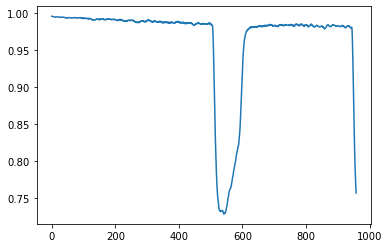

In [6]:
plt.plot(SC_values_ref[:-1])

In [7]:

###print(SC_values_ref)
###b.reshape(len(b), 1)
###SC_values_ref = numpy_fill(SC_values_ref)

0
0.011901589899480924
-0.021402343129074797


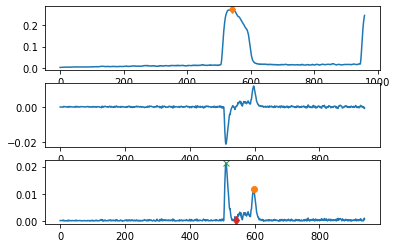

In [8]:
speed = (np.gradient(SC_values_ref[:-20]))

print(np.sum(np.isnan(speed)))
maxSpeed = np.max(speed)
minSpeed = np.min(speed)

speed_Ind_pos, _ = find_peaks(speed, height= maxSpeed*0.7,distance=10)
speed_Ind_neg, _ = find_peaks(-speed, height= -minSpeed*0.7,distance=10)

maxSC = np.max(1-SC_values_ref[:-20])
dist_peak, _ = find_peaks(1-SC_values_ref[:-20], height= maxSC*0.8,distance=100)

print(maxSpeed)
print(minSpeed)

fig, (ax1,ax2,ax3) = plt.subplots(3,1)

ax1.plot(1-SC_values_ref[:-1])
ax1.plot(dist_peak,1-SC_values_ref[dist_peak],"d")
###ax = plt.subplot(132)
ax2.plot(speed)
ax3.plot(abs(speed))
ax3.plot(speed_Ind_pos,abs(speed[speed_Ind_pos]),"o")
ax3.plot(speed_Ind_neg,abs(speed[speed_Ind_neg]),"x")
ax3.plot(dist_peak,abs(speed[dist_peak]),"d")

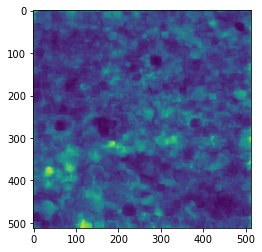

In [9]:
magSum = np.max(magStack,axis=2)
plt.imshow(magSum)

1


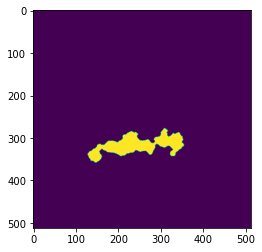

In [10]:
###thresh = threshold_otsu(magSum)

thresh = np.percentile(magSum,80)
mask = magSum>1*thresh

cellMask1 = binary_closing(mask,disk(1))
cellMask2 = ndi.binary_fill_holes(cellMask1)

cellMask3 =  remove_small_objects(cellMask2,200)

###cellMask4 = cellMask3
cellMask4 = binary_closing(cellMask3,disk(2))
cellMask5 = ndi.binary_fill_holes(cellMask4)
cellMask6 = binary_erosion(cellMask5,disk(1))
cellMask7 = binary_opening(cellMask6,disk(3))

cellMask8 =  remove_small_objects(cellMask7,400)
   
cellMask9 = clear_border(cellMask8)

cellMask9 = getLargestCC(cellMask9)

plt.imshow(cellMask9)

mask_label = label(cellMask9)
print(np.max(mask_label))

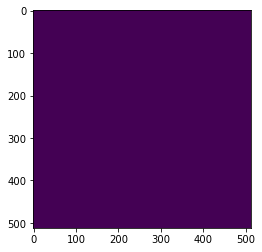

In [11]:
plt.imshow(mask_label)
mask = mask_label==7
plt.imshow(mask)
###mask_size = np.sum(mask)

254862


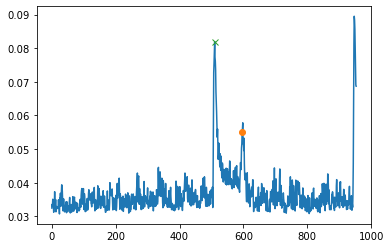

In [12]:
###for ii in range(1,np.max(mask_label)):
for ii in range(0,1):
    mask_region = (mask_label==ii)
    mask_region_stack = np.repeat(mask_region[:, :, np.newaxis], magStack.shape[2], axis=2)
    mask_region_size = np.sum(mask_region)
    print(mask_region_size)
    ##plt.imshow(mask_region_stack[:,:,200])
    magStack_mask = np.multiply(magStack, mask_region_stack.astype(int))
    flow_trace = np.sum(magStack_mask,axis=0)
    flow_trace = np.sum(flow_trace, axis=0)/mask_region_size
    ###flow_trace = np.sum(magStack_mask)/mask_size
    ##plt.imshow(np.log(magStack_mask[:,:,200]+0.001))
    plt.plot(flow_trace[1:-5])
    plt.plot(speed_Ind_pos,flow_trace[speed_Ind_pos],"o")
    plt.plot(speed_Ind_neg,flow_trace[speed_Ind_neg],"x")

    

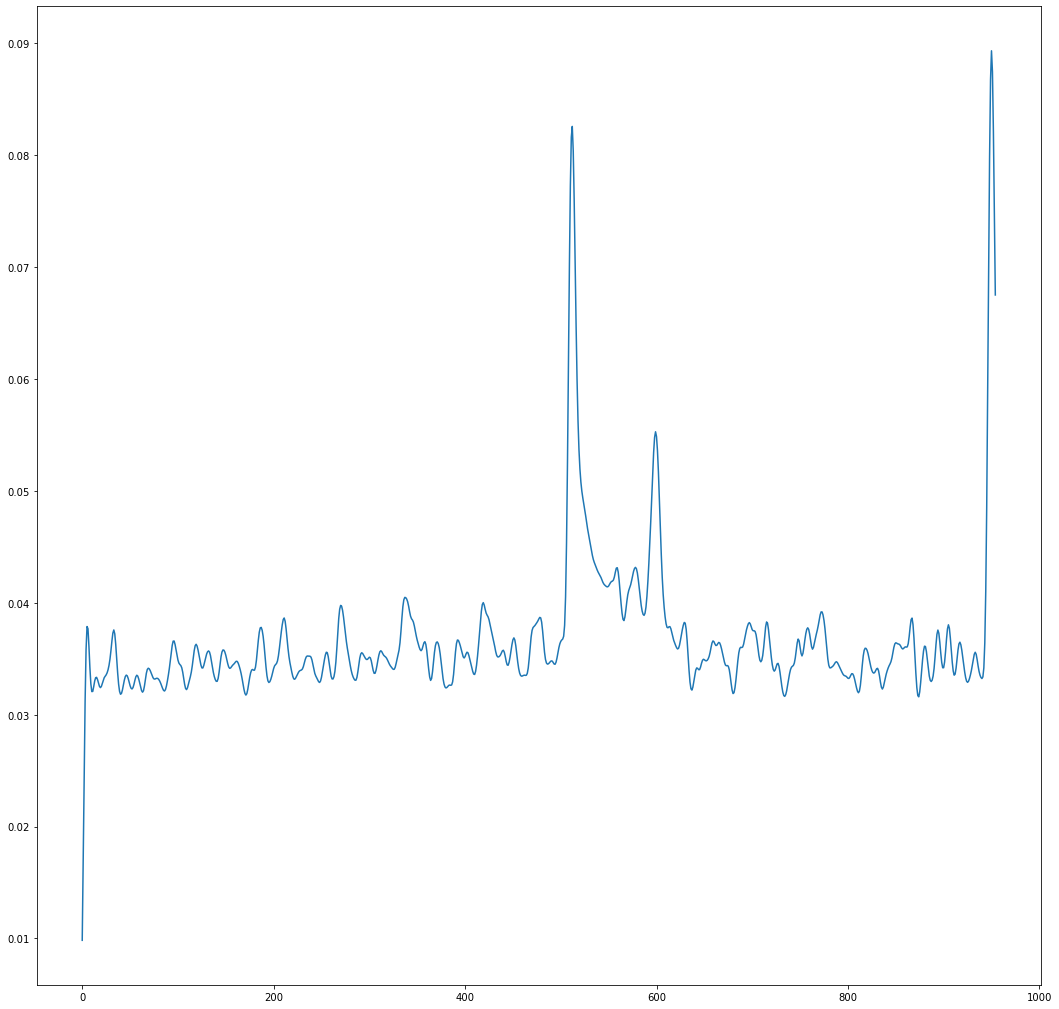

In [20]:
from scipy import signal
sos = signal.butter(5, 10, 'lowpass', fs=100, output='sos')
filtered = signal.sosfilt(sos, flow_trace)
plt.plot(filtered[5:])

In [14]:
print(speed_Ind_pos)
print(speed_Ind_neg)

[597]
[511]


[ 32  95 145 212 269 335 418 511 599 698 748 803 865 948]


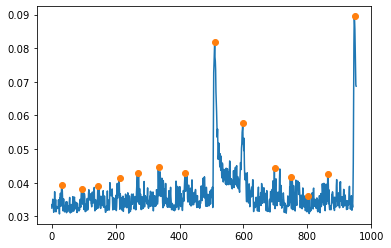

In [15]:
maxVelocity = np.max(flow_trace[1:-5])

peaks_Ind, _ = find_peaks(flow_trace[1:-5], height= maxVelocity*0.15,distance=50)
plt.plot(flow_trace[1:-5])
plt.plot(1+peaks_Ind,flow_trace[1+peaks_Ind],"o")

print(peaks_Ind+1)

In [16]:
speed_Ind_neg
flow_trace

A_list = []
B_list = []

half_width1 = 51 # related to sample freqency
leftBound1 = dist_peak-half_width1
rightBound1 = dist_peak+2

half_width2 = 71 # related to sample freqency
leftBound2 = dist_peak-1
rightBound2 = dist_peak+half_width2


for ii in range(len(leftBound1)):
    if leftBound1[ii]<5 or rightBound1[ii]>len(flow_trace)-20:
        continue
        
    maxV = np.max(flow_trace[leftBound1[ii]:rightBound1[ii]])
    neg_ind = leftBound1[ii]+np.argmax(flow_trace[leftBound1[ii]:rightBound1[ii]])
    A_list.append(neg_ind)
    
for ii in range(len(leftBound2)):
    if leftBound2[ii]<5 or rightBound2[ii]>len(flow_trace)-20:
        continue
        
    maxV = np.max(flow_trace[leftBound2[ii]:rightBound2[ii]])
    pos_ind = leftBound2[ii]+np.argmax(flow_trace[leftBound2[ii]:rightBound2[ii]])
    B_list.append(pos_ind)
    
As = np.array(A_list)
Bs = np.array(B_list)
print(As)
print(Bs)

[511]
[599]


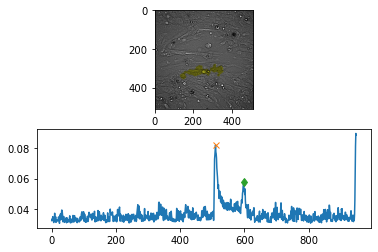

In [17]:
fig, (ax1,ax2) = plt.subplots(2,1)
plt.rcParams['figure.figsize'] = [18, 18]
        ###plt.subplot(211)

alpha = 0.8
img_hsv = color.rgb2hsv(frame1)
color_mask = np.zeros(frame1.shape)
color_mask[...,0] = cellMask9.astype(float)*255
color_mask[...,1] = cellMask9.astype(float)*255
#color_mask[...,2] = magMask.astype(np.float)*255
color_mask_hsv = color.rgb2hsv(color_mask)

img_hsv[..., 0] = color_mask_hsv[..., 0]
img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha
img_masked = color.hsv2rgb(img_hsv)

        
ax1.imshow(img_masked)
ax2.plot(flow_trace[1:-10])
ax2.plot(As,flow_trace[As], "x")
ax2.plot(Bs,flow_trace[Bs], "d")

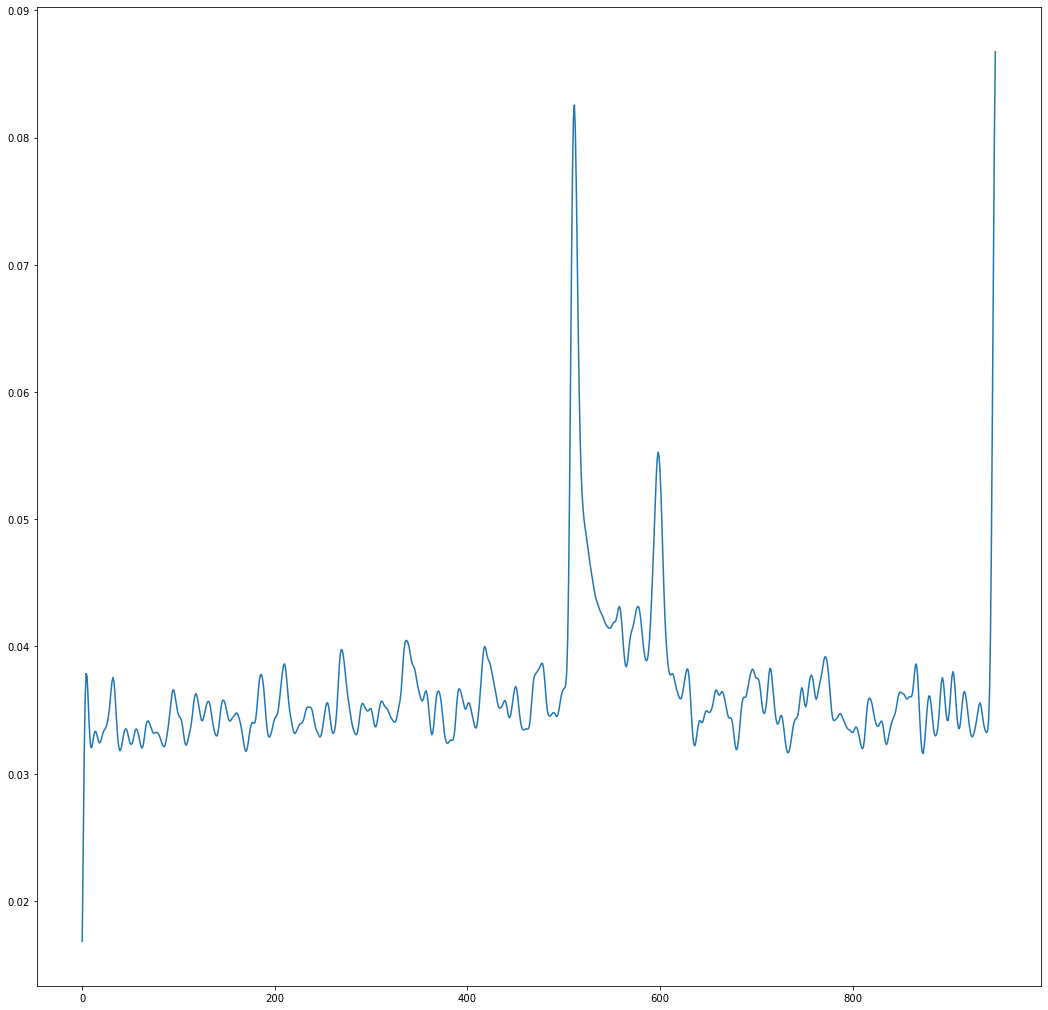

In [18]:
from scipy import signal
sos = signal.butter(5, 10, 'lowpass', fs=100, output='sos')
filtered = signal.sosfilt(sos, flow_trace[1:-5])
plt.plot(filtered[5:])

In [19]:
def estimateTimePoints(videoName, tag, length,speed,peaks,leftBound,rightBound,th = 0.7,register=0):
    A_list = []
    B_list = []
    C_list = []

   
    (dirName,videoFileName) = os.path.split(videoName) 
    for ii in range(len(leftBound)):
        if leftBound[ii]<5 or rightBound[ii]>len(speed):
            continue
        maxV = np.max(speed[leftBound[ii]:rightBound[ii]])
        minV = np.min(speed[leftBound[ii]:rightBound[ii]])       
        pos_ind = peaks[ii]+np.argmax(speed[peaks[ii]:rightBound[ii]])
        neg_ind = leftBound[ii]+np.argmin(speed[leftBound[ii]:peaks[ii]])
        A_ind = leftBound[ii]+np.argmin(np.abs(minV*th-speed[leftBound[ii]:neg_ind]))
        C_ind = neg_ind+np.argmin(np.abs(minV*th-speed[neg_ind:pos_ind]))
        
        D_ind = neg_ind+np.argmin(np.abs(maxV*th-speed[neg_ind:pos_ind]))
        F_ind = pos_ind+np.argmin(np.abs(maxV*th-speed[pos_ind:rightBound[ii]]))
        
        length_min = length[peaks[ii]]
        length_base = np.percentile(length[leftBound[ii]:rightBound[ii]],95)
        
        dH = length_base-length_min
        
        I_ind = peaks[ii]+np.argmin(np.abs(dH*th-(length[peaks[ii]:rightBound[ii]]-length_min)))
        
        A_list.append(A_ind)
        B_list.append(neg_ind)
        C_list.append(C_ind)

        
    print(A_list)
    print(B_list)
    print(C_list)

    
    As = np.array(A_list)
    Bs = np.array(B_list)
    Cs = np.array(C_list)
  
    As = As[:-1]
    Bs = Bs[:-1]
    Cs = Cs[:-1]
    
    
    if len(As):
        fig, (ax1,ax2) = plt.subplots(2,1)
        ###plt.rcParams['figure.figsize'] = [28, 10]
        ###plt.subplot(211)
        ax1.plot(length)
        ax1.plot(Is,length[Is], "x")
        ax1.plot(Is,length[Is-1], "d")
        ax1.plot(Is,length[Is+1], "d")
        ax1.plot(Js,length[Js], "o")
      
        ax1.set_title('NORMALIZED LENGTH CHANGE')
        ###plt.subplot(212)
        ax2.plot(speed)
        ax2.plot(As,speed[As], "x")
        ax2.plot(Bs,speed[Bs], "x")
        ax2.plot(Cs,speed[Cs], "x")
        ax2.plot(Ds,speed[Ds], "D")
        ax2.plot(Es,speed[Es], "D")
        ax2.plot(Fs,speed[Fs], "D")
        ax2.set_title('NORMALIZED SPEED'+ str(th))
        if register:
            displayFigName5 = dirName +'\\' + videoFileName[:-4]+"_segmentation_cell_"+str(tag)+"_quantification_register_part5_th_"+str(round(th*100)) +".jpg"
        else:
            displayFigName5 = dirName +'\\' + videoFileName[:-4]+"_segmentation_cell_"+str(tag)+"_quantification_part5_th_"+str(round(th*100)) +".jpg"
        print("point detection:")
        print(displayFigName5)
        fig.savefig(displayFigName5)
        fig.clf()
        plt.close(fig)
       
    return As,Bs,Cs
        